In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType
import pandas as pd
import os



In [2]:
# Create output directory
os.makedirs("data/labeled", exist_ok=True)



In [4]:
# Load from HDFS
spark = SparkSession.builder.appName("LabelHDFS").getOrCreate()
header = [
    'time', 'EV1000/SV', 'EV1000/CO', 'Solar8000/RR_CO2', 'EV1000/CI', 
    'Solar8000/NIBP_MBP', 'Solar8000/HR', 'EV1000/SVI', 'Solar8000/ART_MBP', 
    'Solar8000/PLETH_SPO2', 'Solar8000/PLETH_HR', 'EV1000/ART_MBP', 
    'caseid', 'age', 'gender', 'height', 'weight', 'bmi'
]

df_cleaned = spark.read.option("header", "false").csv("hdfs://127.0.1.1:9000/cleaned_data", inferSchema=True)

df_cleaned = df_cleaned.toDF(*header)

df_pandas =df_cleaned.toPandas()
print(df_pandas.head())


    time  EV1000/SV  EV1000/CO  Solar8000/RR_CO2  EV1000/CI  \
0  11902       66.0        4.3              14.0        2.0   
1   7914       79.0        5.2              14.0        2.4   
2   8314       82.0        5.4              14.0        2.5   
3   8122       81.0        5.3              14.0        2.4   
4  15552       78.0        5.0              14.0        2.3   

   Solar8000/NIBP_MBP  Solar8000/HR  EV1000/SVI  Solar8000/ART_MBP  \
0                90.0          65.0        30.0               78.0   
1                91.0          66.0        36.0               77.0   
2                91.0          65.0        38.0               75.0   
3                91.0          65.0        37.0               72.0   
4               119.0          63.0        35.0               83.0   

   Solar8000/PLETH_SPO2  Solar8000/PLETH_HR  EV1000/ART_MBP  caseid  age  \
0                 100.0                66.0            65.0    1027   67   
1                 100.0                67.0     

In [6]:
df_pandas = df_pandas[['EV1000/SV', 'Solar8000/RR_CO2', 'Solar8000/NIBP_MBP',
                       'Solar8000/HR', 'Solar8000/PLETH_SPO2', 'Solar8000/PLETH_HR',
                       'EV1000/ART_MBP', 'age', 'height', 'weight']]

# ✅ Calculate body surface area using DuBois formula
df_pandas['body_surface_area'] = 0.007184 * (df_pandas['height'] ** 0.725) * (df_pandas['weight'] ** 0.425)


/tmp/ipykernel_892420/2238457839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['body_surface_area'] = 0.007184 * (df_pandas['height'] ** 0.725) * (df_pandas['weight'] ** 0.425)


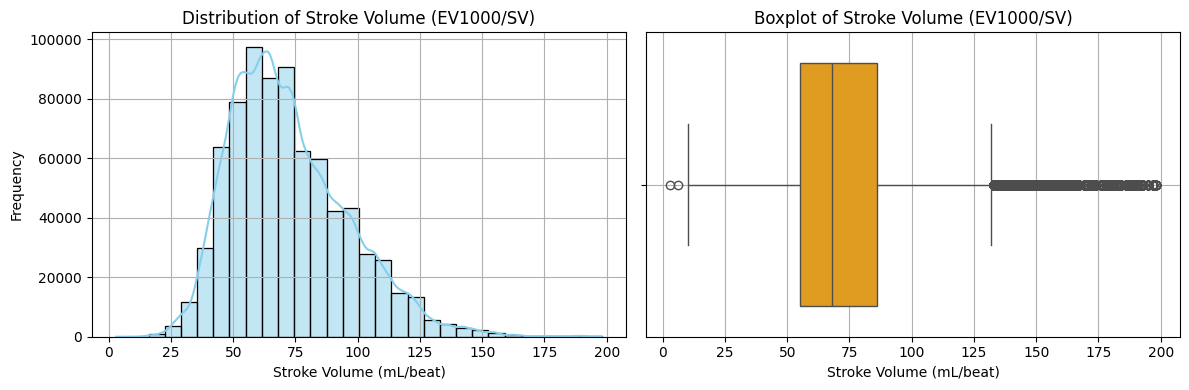

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of SV
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_pandas['EV1000/SV'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Stroke Volume (EV1000/SV)")
plt.xlabel("Stroke Volume (mL/beat)")
plt.ylabel("Frequency")
plt.grid(True)

# Boxplot of SV
plt.subplot(1, 2, 2)
sns.boxplot(x=df_pandas['EV1000/SV'], color='orange')
plt.title("Boxplot of Stroke Volume (EV1000/SV)")
plt.xlabel("Stroke Volume (mL/beat)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
df_pandas[df_pandas['EV1000/SV'] < 70].shape[0]


398596

In [ ]:

# Labeling function
def label_activity(sv):
    if sv < 60:
        return 'sleeping'
    elif 60 <= sv < 75:
        return 'sitting'
    elif 75 <= sv < 90:
        return 'walking'
    else:
        return 'exercising'
    
def label_emotion(sv):
    if sv < 60:
        return 'drowsy'
    elif 60 <= sv < 70:
        return 'relaxed'
    elif 70 <= sv < 85:
        return 'normal'
    else:
        return 'stressed/angry'

In [ ]:
import osRR_CO2

# Apply labeling functions
df_pandas['activity'] = df_pandas['EV1000/SV'].apply(label_activity)
df_pandas['emotion'] = df_pandas['EV1000/SV'].apply(label_emotion)

# Create output folders if they don't exist
os.makedirs("data/labeled_activity", exist_ok=True)
os.makedirs("data/labeled_emotion", exist_ok=True)

# Save by activity
for label in df_pandas['activity'].unique():
    df_subset = df_pandas[df_pandas['activity'] == label].drop(columns=["EV1000/SV", "activity", "emotion"])
    df_subset.to_csv(f"data/labeled_activity/{label}.csv", index=False)
    print(f"✅ Saved activity file: {label}.csv ({len(df_subset)} rows)")

# Save by emotion
for label in df_pandas['emotion'].unique():
    safe_label = label.replace("/", "_")  # filenames can't have slashes
    df_subset = df_pandas[df_pandas['emotion'] == label].drop(columns=["EV1000/SV", "activity", "emotion"])
    df_subset.to_csv(f"data/labeled_emotion/{safe_label}.csv", index=False)
    print(f"✅ Saved emotion file: {safe_label}.csv ({len(df_subset)} rows)")


/tmp/ipykernel_892420/3059246739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['activity'] = df_pandas['EV1000/SV'].apply(label_activity)
/tmp/ipykernel_892420/3059246739.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas['emotion'] = df_pandas['EV1000/SV'].apply(label_emotion)


✅ Saved activity file: sitting.csv (206583 rows)
✅ Saved activity file: walking.csv (136140 rows)
✅ Saved activity file: exercising.csv (170350 rows)
✅ Saved activity file: sleeping.csv (256748 rows)
✅ Saved emotion file: relaxed.csv (141848 rows)
✅ Saved emotion file: normal.csv (162140 rows)
✅ Saved emotion file: stressed_angry.csv (209085 rows)
✅ Saved emotion file: drowsy.csv (256748 rows)
